In [1]:
## Libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation


## Plot settings
plt.rc('xtick', direction='in', labelsize=14)
plt.rc('ytick', direction='in', labelsize=14)
plt.rc('axes', labelsize=20, titlesize=22)
plt.rc('legend', fontsize=14)
plt.rc('animation', html='jshtml')

In [2]:
## Read coordinates and indices

grid_coordinates = []
with open('../Grids/AB_grid.txt', 'r') as reader:
    line = reader.readline()

    while line != '':
        elements = line.split(',')
        point = (float(elements[0]),float(elements[1]))
        grid_coordinates.append(point)
        line = reader.readline()

jump_coordinates = []
with open('../Grids/AB_jump_coordinates.txt', 'r') as reader:
    line = reader.readline()

    while line != '':
        elements = line.split(' ')
        data_block = []
        for ele in elements:
            temp = ele.replace('(', '').replace(')', '')
            if temp != 'stop':
                x = temp.split(',')[0]
                y = temp.split(',')[1]
                point = (float(x),float(y))
                data_block.append(point)
            else:
                break
        line = reader.readline()
        jump_coordinates.append(data_block)

jump_indices = []
with open('../Grids/AB_jump_indices.txt', 'r') as reader:
    line = reader.readline()

    while line != '':
        elements = line.split(' ')
        data_block = []
        for ele in elements:
            if ele != 'stop':
                data_block.append(int(ele))
            else:
                break
        line = reader.readline()
        jump_indices.append(data_block)


bott_indices = []
with open('Bott_indices.txt', 'r') as reader:
    line = reader.readline()
    
    while line != '':
        ele = line.replace('(', '').replace(')', '')
        elements = ele.split(',')
        package = (float(elements[0]), int(elements[1]))
        line = reader.readline()
        bott_indices.append(package)

# For drawing vertices use grid_coordinates
# For drawing lines use jump_coordinates
# For indices use jump_indices
# For bott indices and the indices of topological relevant eigenstates use bott_indices 

In [3]:
## We now want to scale down the plot so it will fit inside a unit square in the 1st quadrant

# Compare x and y components seperatly to for the maximal distances along each axis
xs = [x for x,y in grid_coordinates]
ys = [y for x,y in grid_coordinates]

xs_length = abs(max(xs)) + abs(min(xs))
ys_length = abs(max(ys)) + abs(min(ys))

# We can now scale all xs and ys to fit inside a unit square
xs_scaled = [i/xs_length for i in xs]
ys_scaled = [i/ys_length for i in ys]
grid_scaled = [(x,y) for x, y in zip(xs_scaled, ys_scaled)]

# Same thing for all jump coodinates
jump_scaled = []
for i in jump_coordinates:
    xs_temp = [j[0]/xs_length for j in i]
    ys_temp = [j[1]/ys_length for j in i]
    jump_temp = [(x,y) for x, y in zip(xs_temp, ys_temp)]
    jump_scaled.append(jump_temp)


# The new vertices are stored in grid_scaled
# The new jumps are stored in jump_scaled


## Now we want to move the grid so it lies in the first quadrant 

# We check how much it should be moved along postive x axis and y axis
x_move = min(xs_scaled)
y_move = min(ys_scaled)

# Add the absolute to every coordinate
xs_final = [x + abs(x_move) for x in xs_scaled]
ys_final = [y + abs(y_move) for y in ys_scaled]
grid_final = [(x,y) for x, y in zip(xs_final, ys_final)]

jump_final = []
for i in jump_scaled:
    xs_temp = [j[0] + abs(x_move) for j in i]
    ys_temp = [j[1] + abs(y_move) for j in i]
    jump_temp = [(x,y) for x, y in zip(xs_temp, ys_temp)]
    jump_final.append(jump_temp)


# The new vertices are stored in grid_final
# The new jumps are stored in jump_final

In [4]:
## DEFINITION OF USEFUL FUNCTIONS

def Hamil_solve(z, w, B):
    # Define now a skeleton of the Hamiltonian 
    dim_H = len(z)
    H = np.zeros((dim_H, dim_H), dtype= np.complex128)
    k_H = [x for x in range(0, dim_H)]
    # Calculate Peierls phase factor according to the 1st artcle 
    
    # Start by finding the tile length
    tile_lens = [np.linalg.norm(np.array(z[0]) - np.array(x)) for x in w[0]]
    tile_lens_sum = np.sum(tile_lens)
    l  = tile_lens_sum/len(tile_lens)
    phi = B * l**2
    phi_0 = 2 * np.pi
    jump_products = []
    for i, j in zip(z, w):
        products = [(k[1] - i[1]) * (i[0] + k[0]) for k in j]
        jump_products.append(products)
    phase_factors = []
    for i, j in zip(z, jump_products):
        phases = [(phi/(2 * l**2)) * k for k in j]
        phase_factors.append(phases)

    # Scaling via J, maybe energy factor
    J = 1
    # Fill out the Hamiltonian according to the psi vector, i.e. the basis chosen through generation of the tiling
    for x, y, z in zip(k_H, jump_indices, phase_factors):
        for k, t in zip(y, z):
            H[x, k] = -J * np.exp(1j * t)

    # Now we find the eigenvalues and eigenvectors
    # Note that eigh returns normalized eigenvectors!
    # Note the eigenvectors are arranged in a matrix so eig_vecs[:,i] chooses the i'th column which is the i'th eigenvector
    eig_vals, U = np.linalg.eigh(H)
    eig_vecs = np.array([U[:,i] for i in range(len(U))])
    return eig_vals, eig_vecs

In [5]:
# We want to know when phi/phi0 = 1, this happens when phi = 2pi
# phi in this case is phi = B*l*2 so B must be equal to
B_full = (2*np.pi)/(0.03825242185233838**2)

# Take field strength of B= 2pi so that phi/phi0= 0.5
evals, evecs = Hamil_solve(grid_final, jump_final, (0.25)*B_full)

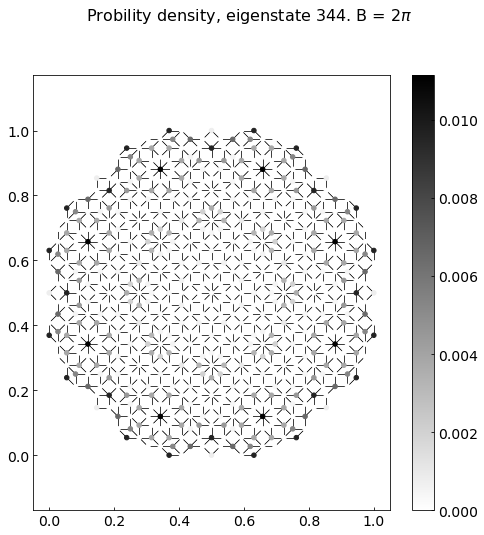

In [6]:
B_full = (2*np.pi)/(0.03825242185233838**2)
evals, evecs = Hamil_solve(grid_final, jump_final, (0.25)*B_full)

# Define colour gradients
gradient = np.linspace(0, 1, 256)
gradient = np.vstack((gradient, gradient))

state = 344

fig, ax = plt.subplots(figsize= (8,8))
# We may multiply every entry of the conjugate with its partner non conjugated since we are working with and orthonormal basis of eigenvectors
# Normalization stems from eigh, and orthonality from each site being a part of orthogonal basis
prob_mid = [x.real for x in evecs[state].conj() * evecs[state]]
# Plot all possible paths between vertices
for i,j in zip(grid_final,jump_final):
    xs = [w[0] for w in j]
    ys = [w[1] for w in j]
    for l,k in zip(xs,ys):
        ax.plot([i[0], l], [i[1], k], color= 'k', linewidth= 0.5)

prob_mid_norm = [x/max(prob_mid) for x in prob_mid]

marker_size = 20

xs = [w[0] for w in grid_final]
ys = [w[1] for w in grid_final]

# One for skeleton plotting
#ax.scatter(x= xs, y= ys, s= marker_size, facecolor= 'w', edgecolor= 'k', label= "Vertex", linewidth= 1, zorder= 2)

# Set colour gradient
plt.set_cmap('binary')

# Plot, noting c sets the density
cax = ax.scatter(x= xs, y= ys, s= marker_size, c= prob_mid, zorder= 3, facecolor= 'r')
# Attach colorbar
fig.colorbar(cax)

# Finalize
plt.axis('equal')
plt.suptitle(r'Probility density, eigenstate {}. B = 2$\pi$'.format(state), y= 1, fontsize= 16)

plt.show()

In [7]:
## Attempt at making a localised particle move in time in terms BLT

# This one take a state and localises a particle to a site in terms of topological interesting eigenstates
def time_evolve(state, time, evec, eval, bott):

    hbar = 1
    # Calculate changes to the state chosen from relevant Bott indice = 1 being index 81

    phi0 = np.zeros(len(eval), dtype= np.complex128)
    phi0[state] = 1

    # Define the time evolution a state 
    # We take the inner product of localised particle and all eigenstates of the hamilton
    # The coefficients will be used for creating phi as a linear combination of eigenstates
    cns = [np.vdot(x, phi0) for x in evec]

    # We can write phi in the basis of eigenstates for the hamiltonian
    # This amounts to selecting cns where the bott index is B != 0
    phi = np.zeros(len(eval), dtype= np.complex128)
    for i in bott:
        phi[i[1]] = cns[i[1]]

    phi_norm_initial = phi / (np.sqrt(np.vdot(phi,phi)))

    # Now we define the Hamiltonian as a diagonal matrix since we have written phi in the basis of eigenstates, thus it will simplify our work
    # We set some timestep t
    t = time
    # Now we construct the time evolution operator by exponentiating every diag entry
    time_op = np.diag([np.exp(-1j*((dval)/(hbar))*t) for dval in eval])
    # Now we apply the time evolution operator to phi
    phi_evolve = np.matmul(time_op, phi_norm_initial)

    # We would like to know what phi is now in the basis of lattice sites. To do this we construct coordinate transformation matrix
    # Start by calculating the inner produts of vdot(ei, sk) for all k this will be the i'th column. s denotes site vectors
    # Site vectors have one entry equal to 1 while the rest are equal to 0. Thus the i,k'th inner product is just selecting the k'th value the i'th vectors complex conjugate
    # This means the coordinate transformation matrix ith column is just the ith eigenvector
    T = np.zeros((len(eval), len(eval)), dtype= np.complex128)
    for i in range(len(eval)):
        T[:, i] = evec[i]
    # Now we can transform phi_evolve into the basis of lattice sites
    phi_lat = np.matmul(T,phi_evolve)
    # phi is normalised 
    phi_norm = phi_lat / (np.sqrt(np.vdot(phi_lat,phi_lat)))
    density_of_states = [x.real for x in phi_norm.conj() * phi_norm]
    return phi_norm, density_of_states

# This bad boy plots 5 time steps
"""state_check = 413
times = [0,5,10,20,25]
phis = [time_evolve(state_check, t, evecs, evals, bott_indices) for t in times]
vec_0, dos0 = phis[0]
max_dos = max(dos0)
fig, ax = plt.subplots(len(times), figsize= (5, 5*len(times)))
# Set colour gradient
plt.set_cmap('binary')
for vecs, t in zip(phis, range(len(times))):
    vec, dos = vecs
    # Plot all possible paths between vertices
    for i,j in zip(grid_final,jump_final):
        xs = [w[0] for w in j]
        ys = [w[1] for w in j]
        for l,k in zip(xs,ys):
            ax[t].plot([i[0], l], [i[1], k], color= 'k', linewidth= 0.5, zorder= 1, alpha= 0.5)

    marker_size = 12

    xs = [w[0] for w in grid_final]
    ys = [w[1] for w in grid_final]

    
    # Plot, noting c sets the densit
    cax = ax[t].scatter(x= xs, y= ys, s= marker_size, c= dos, zorder= 2, vmin=0, vmax= max_dos)
    # Attach colorbar
    fig.colorbar(cax, ax= ax[t])
    ax[t].axis('equal')
plt.show()"""

"state_check = 413\ntimes = [0,5,10,20,25]\nphis = [time_evolve(state_check, t, evecs, evals, bott_indices) for t in times]\nvec_0, dos0 = phis[0]\nmax_dos = max(dos0)\nfig, ax = plt.subplots(len(times), figsize= (5, 5*len(times)))\n# Set colour gradient\nplt.set_cmap('binary')\nfor vecs, t in zip(phis, range(len(times))):\n    vec, dos = vecs\n    # Plot all possible paths between vertices\n    for i,j in zip(grid_final,jump_final):\n        xs = [w[0] for w in j]\n        ys = [w[1] for w in j]\n        for l,k in zip(xs,ys):\n            ax[t].plot([i[0], l], [i[1], k], color= 'k', linewidth= 0.5, zorder= 1, alpha= 0.5)\n\n    marker_size = 12\n\n    xs = [w[0] for w in grid_final]\n    ys = [w[1] for w in grid_final]\n\n    \n    # Plot, noting c sets the densit\n    cax = ax[t].scatter(x= xs, y= ys, s= marker_size, c= dos, zorder= 2, vmin=0, vmax= max_dos)\n    # Attach colorbar\n    fig.colorbar(cax, ax= ax[t])\n    ax[t].axis('equal')\nplt.show()"

In [8]:
# Plot first time evolution of every state for searching for ES

"""for s in range(len(evals)):
#for s in [0,1]:
    state_check = s
    times = [0,10,20]
    phis = [time_evolve(state_check, t, evecs, evals, bott_indices) for t in times]
    vec_0, dos0 = phis[0]
    max_dos = max(dos0)
    fig, ax = plt.subplots(len(times), figsize= (6, 6*len(times)))
    # Set colour gradient
    plt.set_cmap('binary')
    for vecs, t in zip(phis, range(len(times))):
        vec, dos = vecs
        # Plot all possible paths between vertices
        #for i,j in zip(grid_final,jump_final):
         #   xs = [w[0] for w in j]
          #  ys = [w[1] for w in j]
           # for l,k in zip(xs,ys):
            #    ax[t].plot([i[0], l], [i[1], k], color= 'k', linewidth= 0.5, zorder= 1, alpha= 0.5)

        marker_size = 12

        xs = [w[0] for w in grid_final]
        ys = [w[1] for w in grid_final]

        
        # Plot, noting c sets the densit
        cax = ax[t].scatter(x= xs, y= ys, s= marker_size, c= dos, zorder= 2, vmin=0, vmax= max_dos)
        # Attach colorbar
        fig.colorbar(cax, ax= ax[t])
        ax[t].axis('equal')
    plt.savefig(f'../BLT_search/state_{s}.png')
    plt.close(fig)
    plt.clf()"""

"for s in range(len(evals)):\n#for s in [0,1]:\n    state_check = s\n    times = [0,10,20]\n    phis = [time_evolve(state_check, t, evecs, evals, bott_indices) for t in times]\n    vec_0, dos0 = phis[0]\n    max_dos = max(dos0)\n    fig, ax = plt.subplots(len(times), figsize= (6, 6*len(times)))\n    # Set colour gradient\n    plt.set_cmap('binary')\n    for vecs, t in zip(phis, range(len(times))):\n        vec, dos = vecs\n        # Plot all possible paths between vertices\n        #for i,j in zip(grid_final,jump_final):\n         #   xs = [w[0] for w in j]\n          #  ys = [w[1] for w in j]\n           # for l,k in zip(xs,ys):\n            #    ax[t].plot([i[0], l], [i[1], k], color= 'k', linewidth= 0.5, zorder= 1, alpha= 0.5)\n\n        marker_size = 12\n\n        xs = [w[0] for w in grid_final]\n        ys = [w[1] for w in grid_final]\n\n        \n        # Plot, noting c sets the densit\n        cax = ax[t].scatter(x= xs, y= ys, s= marker_size, c= dos, zorder= 2, vmin=0, vmax= ma

In [9]:
"""## Magic line for animation
%matplotlib inline
# Attempt at animating time evolution

# Set figure up first
fig, ax = plt.subplots(figsize=(6,6))
# Set bascis
sites = ax.scatter(x=[], y=[], c=[])

xs = [w[0] for w in grid_final]
ys = [w[1] for w in grid_final]


# Set timesteps, state of choice for animation, and number of frames
timestep = 0.1
state_of_choice = 344
n_frames = 250

vecs, dos_max = time_evolve(state_of_choice, 0, evecs, evals, bott_indices)

plt.set_cmap('binary')
#cax = ax.scatter(x= xs, y= ys, s= marker_size, c= dos_max, zorder= 2)


# This function will do the animating
def update(i):
    plt.clf()
    # t is the steps we progress, timestep sets the steplength
    t = i * timestep

    # Using the time evolution to find density of states for each increment
    vecs, dos = time_evolve(state_of_choice, t, evecs, evals, bott_indices)
    cf = plt.scatter(x= xs, y= ys, c= dos, vmin=0, vmax= max(dos_max))
    #plt.scatter(x= xs, y= ys, c= dos, vmin=0, vmax= max(dos_max))
    plt.colorbar(cf)
    plt.axis('equal')


anim = FuncAnimation(fig, update, frames= n_frames, interval=50)

anim.save(F'animation_es_state_{state_of_choice}.gif', writer='imagemagick', fps=30)

anim"""

"## Magic line for animation\n%matplotlib inline\n# Attempt at animating time evolution\n\n# Set figure up first\nfig, ax = plt.subplots(figsize=(6,6))\n# Set bascis\nsites = ax.scatter(x=[], y=[], c=[])\n\nxs = [w[0] for w in grid_final]\nys = [w[1] for w in grid_final]\n\n\n# Set timesteps, state of choice for animation, and number of frames\ntimestep = 0.1\nstate_of_choice = 344\nn_frames = 250\n\nvecs, dos_max = time_evolve(state_of_choice, 0, evecs, evals, bott_indices)\n\nplt.set_cmap('binary')\n#cax = ax.scatter(x= xs, y= ys, s= marker_size, c= dos_max, zorder= 2)\n\n\n# This function will do the animating\ndef update(i):\n    plt.clf()\n    # t is the steps we progress, timestep sets the steplength\n    t = i * timestep\n\n    # Using the time evolution to find density of states for each increment\n    vecs, dos = time_evolve(state_of_choice, t, evecs, evals, bott_indices)\n    cf = plt.scatter(x= xs, y= ys, c= dos, vmin=0, vmax= max(dos_max))\n    #plt.scatter(x= xs, y= ys, c=